In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression as LR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score, explained_variance_score as EVS, mean_squared_error as MSE
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.datasets import load_wine

In [2]:
pd.set_option('display.width', 100) 

### 数据集分类及标准化

In [56]:
df = pd.read_excel('/Users/19723/Desktop/result.xlsx')
# df.sort_values(by=['h'])
zscore = preprocessing.StandardScaler()
# zscore标准化
zscore = zscore.fit_transform(df)
df_zscore = pd.DataFrame(zscore,index=df.index,columns=df.columns)
modeldata = df_zscore.head(100)
# testdata = df_zscore.drop(labels=range(0,48),axis=0)
# modeldata1 = df_zscore.head(100).drop(labels=range(0,12),axis=0)
modeldata

,y,单价,GDP,GDP增速,租金环比,租金同比,空置率,商业供应土地数量,商业供应土地面积
0,1.837992,-1.314877,-0.173246,-0.934033,-1.338884,0.594042,-0.215263,0.350493,0.191585
1,0.934435,0.255882,2.967257,0.541477,-0.462634,0.817147,0.540848,2.725362,2.776131
2,0.858751,0.471227,-0.294771,0.048922,0.550259,1.417652,1.786008,-0.549677,0.076281
3,0.350326,2.181327,-0.109764,-0.585106,0.112134,1.373865,-0.035317,-0.602611,-0.613720
4,0.333611,-1.023526,-0.512269,0.604501,2.289745,-0.727905,-0.679591,0.653744,0.452775
5,-0.308073,0.306551,-0.381203,-2.366054,-1.026557,-0.183696,-2.139173,-0.625525,-0.597415
6,-0.475691,0.737243,-0.192380,0.320479,0.764983,0.260428,0.052975,-0.506870,-0.565977
7,-0.746851,-1.023526,-0.243295,0.183728,-0.892083,-1.586961,-0.676059,-0.494435,-0.513718
8,-1.288707,0.103873,-0.543407,1.098437,0.012363,-1.017732,0.824053,-0.554352,-0.620682
9,-1.495792,-0.694174,-0.516920,1.087651,-0.009326,-0.946839,0.541520,-0.396128,-0.585260


### 模型线性回归取系数

In [60]:
# 小写的 ols 函数才会自带截距项，OLS 则不会
# 固定格式：因变量 ~ 自变量(+ 号连接)
# 15 - 19 模型
lm1 = ols('y ~ 单价 + GDP + GDP增速 + 租金环比 + 租金同比 + 空置率 + 商业供应土地数量 + 商业供应土地面积', data=modeldata).fit()
lm1.summary()

# # 16-19模型
# lm2 = ols('y ~ 单价 + GDP + GDP增速 + 租金环比 + 租金同比 + 空置率 + 商业供应土地数量 + 商业供应土地面积', data=modeldata1).fit()
# lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     3.586
Date:                Fri, 16 Jul 2021   Prob (F-statistic):              0.388
Time:                        14:28:52   Log-Likelihood:                 2.7647
No. Observations:                  10   AIC:                             12.47
Df Residuals:                       1   BIC:                             15.19
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.551e-17      0.184   3.02e-16      1.000      -2.332       2.332
单价             0.1078      0.721      0.150      0.905      -9.050       9.266
GDP           -2.9720      2.280     -1.304      0.417     -31.937      25.993
GDP增速          2.7521      2.345      1.173      0.449     -27.049      32.553
租金环比          -1.4709      1.183     -1.244      0.431     -16.498      13.556
租金同比           2.2839      1.162      1.966      0.300     -12.478      17.046
空置率           -2.5446      2.001     -1.272      0.424     -27.965      22.876
商业供应土地数量      -2.8222      2.855     -0.988      0.504     -39.100      33.456
商业供应土地面积       5.3230      4.250      1.252      0.429     -48.683      59.329
==============================================================================
Omnibus:                        3.836   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                1.167
Skew:                          -0.793   Prob(JB):                        0.558
Kurtosis:                       3.536   Cond. No.                         61.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
def vif(df, col_i):
    """
    df: 整份数据
    col_i：被检测的列名
    """
    cols = list(df_zscore.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)

In [62]:
t = modeldata[['单价', 'GDP', 'GDP增速', '租金环比', '租金同比', '空置率', '商业供应土地数量', '商业供应土地面积']]
for i in t.columns:
    print(i, '\t', vif(df=modeldata, col_i=i))

单价 	 15.769664645158619
GDP 	 416.53125449516483
GDP增速 	 388.19422817703327
租金环比 	 105.76510613126855
租金同比 	 194.94686658203028
空置率 	 311.0822053151446
商业供应土地数量 	 478.515127114424
商业供应土地面积 	 1377.6386559228226


### 单独的score

C:\Users\19723\anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\19723\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\19723\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20538 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\19723\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 31038 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\19723\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20250 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\19723\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 280

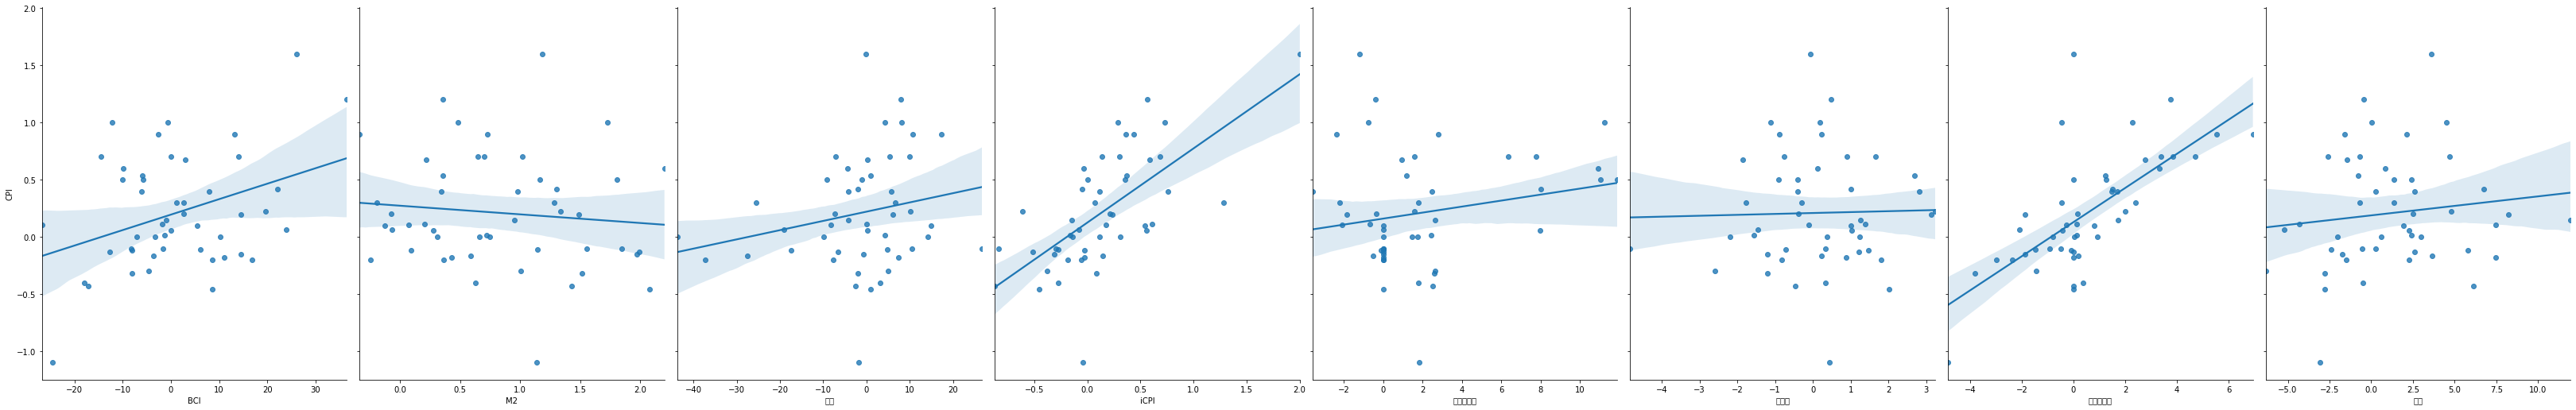

In [19]:
# 通过加入一个参数kind='reg'，seaborn可以添加一条最佳拟合直线和95%的置信带。
sns.pairplot(modeldata1, x_vars=['BCI', 'M2', '国债', 'iCPI', '社会消费品', '一揽子', '食用农产品', '南华'], y_vars='CPI', size=7, aspect=0.8,kind = 'reg')
plt.savefig("pairplot.jpg")
plt.show()

In [20]:
X_train = modeldata1.drop(labels='CPI',axis=1)
Y_train = modeldata1['CPI']
X_test = testdata.drop(labels='CPI',axis=1)
Y_test = testdata['CPI']
 
# print("原始数据特征:",df_zscore.iloc[:,1:9].shape,
#       ",训练数据特征:",X_train.shape,
#       ",测试数据特征:",X_test.shape)
 
# print("原始数据标签:",df_zscore.CPI.shape,
#       ",训练数据标签:",Y_train.shape,
#       ",测试数据标签:",Y_test.shape)

model = LR()
model.fit(X_train,Y_train)
a  = model.intercept_#截距
b = model.coef_#回归系数
print("最佳拟合线:截距",a,",回归系数：",b)

最佳拟合线:截距 -0.033843774312187075 ,回归系数： [ 0.00710472  0.0851286   0.00421877  0.55803495  0.01540988 -0.01888468
  0.10290077  0.0116498 ]


In [24]:
#R方检测
#决定系数r平方
#对于评估模型的精确度
#y误差平方和 = Σ(y实际值 - y预测值)^2
#y的总波动 = Σ(y实际值 - y平均值)^2
#有多少百分比的y波动没有被回归拟合线所描述 = SSE/总波动
#有多少百分比的y波动被回归线描述 = 1 - SSE/总波动 = 决定系数R平方
#对于决定系数R平方来说1） 回归线拟合程度：有多少百分比的y波动刻印有回归线来描述(x的波动变化)
#2）值大小：R平方越高，回归模型越精确(取值范围0~1)，1无误差，0无法完成拟合
score = model.score(X_test,Y_test)
print(score)
#对线性回归进行预测
Y_pred = model.predict(X_test)

0.7184976137148937


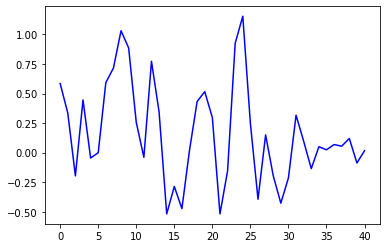

In [22]:
plt.figure()
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.show()

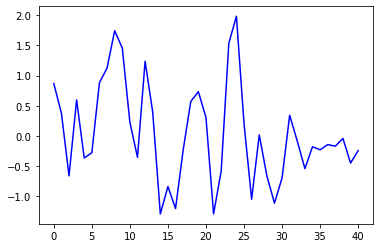

In [14]:
plt.figure()
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.show()

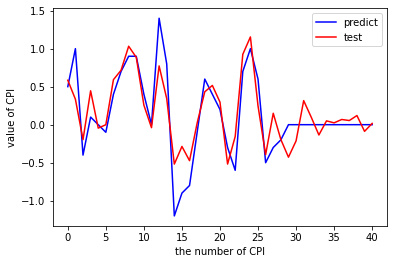

In [52]:
plt.figure()
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of CPI")
plt.ylabel('value of CPI')
plt.savefig("ROC.jpg")
plt.show()

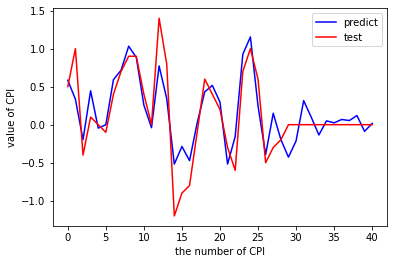

In [303]:
plt.figure()
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of CPI")
plt.ylabel('value of CPI')
plt.savefig("ROC.jpg")
plt.show()

### 随机森林

In [177]:
df = pd.read_excel('/Users/19723/Desktop/result.xlsx')
# df.sort_values(by=['h'])
zscore = preprocessing.StandardScaler()
# zscore标准化
df1 = df['同比涨跌']
df = df.drop(columns='同比涨跌')
zscore = zscore.fit_transform(df)
df_zscore = pd.DataFrame(zscore,index=df.index,columns=df.columns)
modeldata = df_zscore.head(100)
# testdata = df_zscore.drop(labels=range(0,48),axis=0)
# modeldata1 = df_zscore.head(60).drop(labels=range(0,12),axis=0)

In [178]:
modeldata

,y,单价,GDP,GDP增速,租金环比,租金同比,空置率,商业供应土地数量,商业供应土地面积
0,1.837992,-1.314877,-0.173246,-0.934033,-1.338884,0.594042,-0.215263,0.350493,0.191585
1,-0.746851,-1.023526,-0.243295,0.183728,-0.892083,-1.586961,-0.676059,-0.494435,-0.513718
2,-0.308073,0.306551,-0.381203,-2.366054,-1.026557,-0.183696,-2.139173,-0.625525,-0.597415
3,0.858751,0.471227,-0.294771,0.048922,0.550259,1.417652,1.786008,-0.549677,0.076281
4,0.350326,2.181327,-0.109764,-0.585106,0.112134,1.373865,-0.035317,-0.602611,-0.613720
5,-0.475691,0.737243,-0.192380,0.320479,0.764983,0.260428,0.052975,-0.506870,-0.565977
6,-1.495792,-0.694174,-0.516920,1.087651,-0.009326,-0.946839,0.541520,-0.396128,-0.585260
7,0.333611,-1.023526,-0.512269,0.604501,2.289745,-0.727905,-0.679591,0.653744,0.452775
8,0.934435,0.255882,2.967257,0.541477,-0.462634,0.817147,0.540848,2.725362,2.776131
9,-1.288707,0.103873,-0.543407,1.098437,0.012363,-1.017732,0.824053,-0.554352,-0.620682


In [179]:
X_train = modeldata.head(9)
Y_train = df1.head(9)
X_test = modeldata.tail(4)
Y_test = df1.tail(4)

In [180]:
Y_test

6    4
7    3
8    2
9    1
Name: 同比涨跌, dtype: int64

In [181]:
# X_train = modeldata.drop(labels='CPI',axis=1)
# Y_train = df.head(60).drop(labels=range(0,12),axis=0)['CPI']
# X_test = testdata.drop(labels='CPI',axis=1)
# Y_test = df.drop(labels=range(0,48),axis=0)['CPI']
 
# # print("原始数据特征:",df_zscore.iloc[:,1:9].shape,
# #       ",训练数据特征:",X_train.shape,
# #       ",测试数据特征:",X_test.shape)
 
# # print("原始数据标签:",df_zscore.CPI.shape,
# #       ",训练数据标签:",Y_train.shape,
# #       ",测试数据标签:",Y_test.shape)

# clf = tree.DecisionTreeClassifier(criterion='entropy')
# clf = clf.fit(X_train,Y_train)
# score = clf.score(X_test,Y_test)

In [182]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train,Y_train)
score = clf.score(X_test,Y_test)

In [183]:
abc = pd.DataFrame(clf.feature_importances_)
abc

,0
0,0.000000
1,0.166667
2,0.000000
3,0.240270
4,0.210310
5,0.000000
6,0.000000
7,0.000000
8,0.382753


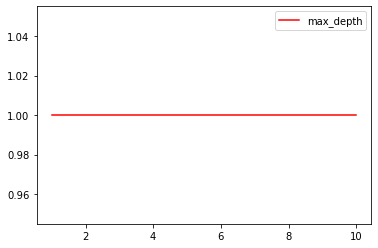

In [151]:
# 如何确定每个参数的值？
# 使用确定超参数的曲线来判断
# 即：超参数的学习曲线，是一条以超参数的取值为横坐标，模型的度量指标为纵坐标的曲线，用来衡量不同超参数取值下模型的表现的线
# 在我们建好的决策树里，我们的模型度量指的就是score

test = []
for i in range(10):
    clf = tree.DecisionTreeClassifier(max_depth=i+1,
                                     criterion='entropy',
                                     random_state=30
                                     )
    clf = clf.fit(X_train,Y_train)
    score = clf.score(X_test,Y_test)
    test.append(score)   
plt.plot(range(1,11),test,color='red',label='max_depth')
plt.legend()
plt.show()

### 多元非线性

In [142]:
x = df_zscore[['BCI', 'M2', '国债', 'iCPI', '社会消费品', '一揽子', '食用农产品', '南华']]
y = df_zscore['CPI']

In [143]:
po = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
x_poly = po.fit_transform(x)
pd.DataFrame(x_poly)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.204601,0.948124,-0.227009,-0.250478,0.468027,-2.106032,-0.138272,-0.382779,1.451062,-1.142110,...,0.219049,-0.985679,-0.064715,-0.179151,4.435370,0.291205,0.806144,0.019119,0.052927,0.146519
1,2.504217,-0.113002,-0.977319,-0.250478,-1.074289,0.484965,-0.138272,0.042165,6.271103,-0.282981,...,1.154097,-0.520993,0.148544,-0.045298,0.235191,-0.067057,0.020449,0.019119,-0.005830,0.001778
2,-0.869100,2.296485,1.477003,-0.250478,1.966900,1.185143,-0.138272,-0.431102,0.755334,-1.995874,...,3.868694,2.331058,-0.271967,-0.847934,1.404565,-0.163872,-0.510918,0.019119,0.059609,0.185849
3,-0.599815,-0.157071,1.802639,-0.250478,-0.552000,-0.222175,-0.138272,-0.377526,0.359778,0.094214,...,0.304704,0.122641,0.076326,0.208394,0.049362,0.030721,0.083877,0.019119,0.052201,0.142526
4,0.859604,0.442323,1.179362,-0.250478,-0.552000,0.490906,-0.138272,0.661839,0.738919,0.380223,...,0.304704,-0.270980,0.076326,-0.365335,0.240988,-0.067878,0.324901,0.019119,-0.091514,0.438031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.523565,0.025110,-0.254371,0.079965,2.870883,0.820815,0.513057,0.460385,0.274120,0.013147,...,8.241968,2.356462,1.472927,1.321712,0.673736,0.421125,0.377891,0.263228,0.236204,0.211955
68,-0.439898,0.062112,1.654331,0.410408,0.682543,0.328062,-0.096771,-0.736040,0.193510,-0.027323,...,0.465864,0.223917,-0.066050,-0.502379,0.107625,-0.031747,-0.241467,0.009365,0.071227,0.541755
69,0.015568,-1.532908,-0.990007,0.275870,-1.555224,2.140000,-1.812045,-0.165039,0.000242,-0.023864,...,2.418722,-3.328180,2.818137,0.256673,4.579601,-3.877778,-0.353184,3.283509,0.299058,0.027238
70,1.381988,-0.006965,-0.168403,-0.817188,0.527731,1.900149,-0.962064,0.205221,1.909890,-0.009626,...,0.278500,1.002768,-0.507711,0.108302,3.610567,-1.828065,0.389951,0.925567,-0.197436,0.042116


In [144]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(x_poly, y, test_size = 0.2, random_state = 1)

In [145]:
reg2 = LR().fit(X_train2, Y_train2)
yhat2 = reg2.predict(X_test2)
yhat2

array([ 3.11858109,  3.26129176, -0.18932757,  0.61617048,  1.00504783,
        0.21331117, -3.80037426,  0.51245729,  0.68989254,  0.58202749,
       -1.63606029, -2.33449111,  0.7724817 ,  1.5876827 , -0.25092904])

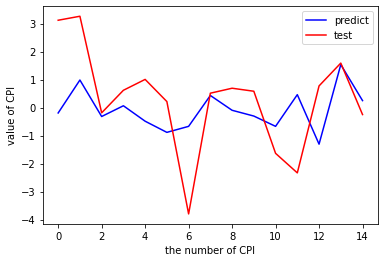

In [150]:
plt.figure()
plt.plot(range(len(yhat2)),Y_test2,'b',label="predict")
plt.plot(range(len(yhat2)),yhat2,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of CPI")
plt.ylabel('value of CPI')
plt.savefig("ROC.jpg")
plt.show()